
### Objectiu del departament d'Anàlisi de Perfil Client:

> Quines combinacions de característiques demogràfiques (com edat, nivell educatiu i ocupació) són més comunes entre els clients que utilitzen múltiples productes financers del banc: loan, hipoteca, dipòsit?

### Llibreries i càrrega de dades

In [17]:
"""Libreries que poden ser necessàries"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Clustering y agrupamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


In [18]:
# %pip install plottable
# %pip install kmodes


In [19]:
df = pd.read_csv("../Data/df_250519.csv")

Paleta de colors

In [20]:
custom_palette = ["#AABBC8", "#2CCED1", "#5F6F81", "#DCE3EA", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

### Extracte KPIs

In [21]:

# Variables 
contactados   = df.nunique().id                                     # Número total de clientes contactados
suscribieron  = df[df['deposit'] == True].nunique().id             # Número de clientes que suscribieron 
duracion_llam = df[df['deposit'] == True].duration.sum()           # Duración de llamadas a suscriptores
llam_telf = df[df['contact'] == 'telephone']['campaign'].sum()      # Número de llamadas realizadas por teléfono
llam_cell = df[df['contact'] == 'cellular']['campaign'].sum()       # Número de llamadas realizadas por movil
llam = df['campaign'].sum()                                         # Número total de llamadas
contatos_previos_sus = df[df['deposit'] == True]['previous'].sum() # Número de contactos previos a suscriptores
suscribieron_por_mes = df[df['deposit'] == True].groupby('month').count()['deposit']  # Suscriptores en el mes
contactos_por_mes = df.groupby('month').count()['deposit']          # clientes contactados en el mes      
conversion_por_mes = suscribieron_por_mes / contactos_por_mes       # conversión por mes


# Prints
print("El número total de clientes contactados es:",contactados)
print("El número de suscriptores es:",suscribieron)
print("La duración total de las llamadas a suscriptores es:",duracion_llam)
print("El número de llamadas realizadas a teléfono fijo es: ", llam_telf)
print("El número de llamadas realizadas a móvil es: ", llam_cell)
print("El número total de llamadas realizadas es: ", llam)
print("El número total de contactos previos de los suscriptores es:", contatos_previos_sus)
print("La conversión por mes es: ", conversion_por_mes)

El número total de clientes contactados es: 16163
El número de suscriptores es: 7712
La duración total de las llamadas a suscriptores es: 4161406
El número de llamadas realizadas a teléfono fijo es:  3274
El número de llamadas realizadas a móvil es:  28002
El número total de llamadas realizadas es:  40513
El número total de contactos previos de los suscriptores es: 9149
La conversión por mes es:  month
Apr    0.632210
Aug    0.456830
Dec    0.910256
Feb    0.579892
Jan    0.408537
Jul    0.413684
Jun    0.447770
Mar    0.903704
May    0.334953
Nov    0.420236
Oct    0.837500
Sep    0.842333
Name: deposit, dtype: float64


In [22]:
#KPIs
kpi1 = suscribieron/contactados          # porcentaje de conversión a depósito
kpi2 = duracion_llam/suscribieron        # promedio de duración de llamadas a suscriptores
kpi3_tel = llam_telf/llam                # porcentaje de llamadas a teléfono
kpi3_cell = llam_cell/llam               # porcentaje de llamadas a móvil
kpi3 = (llam_telf+llam_cell)/llam        # porcentaje de llamadas a teléfono o móvil
kpi4 = contatos_previos_sus/suscribieron # promedio de contactos previos a suscriptores
kpi5 = conversion_por_mes.idxmax()       # mes con mayor tasa de conversión
kpi5_tasa = conversion_por_mes.max()     # tasa de conversión del mes con mayor tasa de conversión




# Prints
print("KPI 1: El porcentaje de conversión a depósito es ",kpi1*100,"%")
print("KPI 2: La duración media de las llamadas a suscriptoreses",kpi2)
# print("KPI 3: El porcentaje de llamadas realizadas por teléfono o móvil es ",kpi3*100,"%")
print("KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es ",kpi3_tel*100,"%")
print("KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es ",kpi3_cell*100,"%")
print("KPI 4: El porcentaje de contactos previos a suscriptores es ",kpi4)
print("KPI 5: El mes amb millor conversió ha sigut", kpi5, "amb una taxa de conversió de", kpi5_tasa)

KPI 1: El porcentaje de conversión a depósito es  47.713914496071276 %
KPI 2: La duración media de las llamadas a suscriptoreses 539.6014004149378
KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es  8.081356601584677 %
KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es  69.11855453804951 %
KPI 4: El porcentaje de contactos previos a suscriptores es  1.1863329875518671
KPI 5: El mes amb millor conversió ha sigut Dec amb una taxa de conversió de 0.9102564102564102


# Anàlisi 

Volem saber, 
de la gent que contracta els tres productes financers del banc:  prèstec (loan), hipoteca (housing), compte d'estalvi (deposit)

Quins són els perfils més comuns (3 variables)?


Comencem filtrant el df per els perfils que contracten aquest tres productes

In [23]:
# Número de clients que van suscriure, tenen prèstec i una hipoteca 
df_3contractats = df[(df['deposit'] == True) & (df['loan'] == True) & (df['housing'] == True)] 

df_3contractats_numero = df_3contractats.nunique().id 
print("El número de clientes que suscribieron, tienen préstamo y una hipoteca es:", df_3contractats_numero)


# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_3contractats = df.groupby(['job', 'marital', 'education'])


# Creem una taula per al càlcul de conversions
taula_pefils = []

# Recorrem la taula calculant la conversió de cada grup
for (feina, estat_civil, educacio), grup in df_3contractats:
    numero = grup.nunique().id

    # Afegim cada resultat a la taula
    taula_pefils.append({
        'job': feina,
        'marital': estat_civil,
        'education': educacio,
        'número': numero,
    })

# Convertim la taula de conversió en un dataframe 
taula_pefils = pd.DataFrame(taula_pefils)

# taula_pefils = taula_pefils.set_index(['feina', 'estat_civil', 'educació'])  # Establim l'índex de la taula

# Ordenem per 
taula_pefils = taula_pefils.sort_values(by='número', ascending=False)  # Ordenem la taula per número de persones

# Reordenem les columnes de la taula

taula_pefils

El número de clientes que suscribieron, tienen préstamo y una hipoteca es: 384


,job,marital,education,número
51,management,married,tertiary,1651
55,management,single,tertiary,1137
16,blue-collar,married,secondary,1078
105,technician,married,secondary,935
5,admin.,married,secondary,796
...,...,...,...,...
91,student,divorced,tertiary,2
53,management,single,primary,2
26,entrepreneur,divorced,unknown,2
23,entrepreneur,divorced,primary,2


## K-modes -> variables categóricas

In [24]:
X = taula_pefils[['job', 'marital', 'education']].copy()

In [25]:
# Perform k-modes clustering
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(X)
# Print the resulting clusters
print(clusters)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 221.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 229.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 201.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 20, cost: 199.0
Best run was number 5
[1 0 1 1 1 1 3 1 3 3 0 3 0 1 0 1 3 2 1 2 1 0 0 1 0 0 0 0 1 0 2 1 0 0 1 2 0
 2 1 1 3 1 1 1 3 0 0 0 2 1 1 1 1 0 1 0 0 0 1 1 1 1 0 3 1 0 0 0 0 0 0 1 1 0
 0 1 0 0 0 2 2 0 0 0 2 3 3 0 1 0 3 1 1 3 2 0 0 0 2 0 2 0 0 1 0 2 1 1 3 2 0
 0 0 2 0 0 0 0 2 2 2 0 1 1 1 1 2 0 1 2 0 2]


## K-prototypes -> variables numéricas y categóricas

#### Prueba 1: 3 clusters

In [32]:
X_proto = taula_pefils[['número', 'job', 'marital', 'education']].copy()


# Convertir columnas categóricas a string
X_proto[['job', 'marital', 'education']] = X_proto[['job', 'marital', 'education']].astype(str)

# Crear instancia
kproto = KPrototypes(n_clusters=3, init='Cao', verbose=0)

# Ajustar modelo y predecir
clusters = kproto.fit_predict(X_proto, categorical=[1, 2, 3])

# Mostrar resultados
print(clusters)

[1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
taula_pefils['cluster'] = clusters
taula_pefils['cluster'].value_counts().sort_index()

cluster
0    112
1      6
2     14
Name: count, dtype: int64

#### Prueba 2: 5 clusters

In [28]:
X_proto = taula_pefils[['número', 'job', 'marital', 'education']].copy()

# Convertir columnas categóricas a string
X_proto[['job', 'marital', 'education']] = X_proto[['job', 'marital', 'education']].astype(str)

# Crear instancia
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=0)

# Ajustar modelo y predecir
clusters = kproto.fit_predict(X_proto, categorical=[1, 2, 3])

# Mostrar resultados
print(clusters)

[4 4 4 4 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [29]:
taula_pefils['cluster'] = clusters
taula_pefils['cluster'].value_counts().sort_index()

cluster
0    26
1    86
2     6
3    10
4     4
Name: count, dtype: int64

### Elbow method para encontrar k óptimo
Calculo el costo para diferentes valores de l entre 2 - 9 (inclusive)

https://es.wikipedia.org/wiki/M%C3%A9todo_del_codo_(agrupamiento)
El método consiste en graficar la variación explicada en función del número de conglomerados y elegir el codo de la curva como el número de conglomerados a utilizar. Utilizar el "codo" o la "rodilla de una curva" como punto de corte es un método común en la optimización matemática para elegir aquel punto a partir del cual los rendimientos decrecientes ya no justifican el costo adicional.

En este caso, el codo está en el 4.

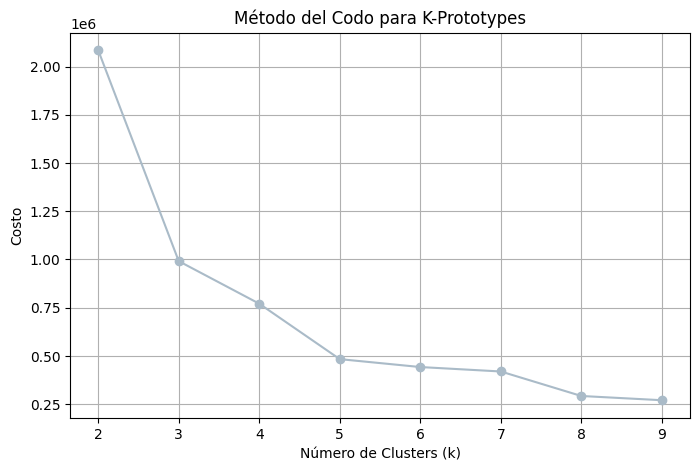

In [30]:
costs = []
ks = list(range(2, 10))

for k in ks:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    clusters = kproto.fit_predict(X_proto, categorical=[1, 2, 3])
    costs.append(kproto.cost_)

# Graficar la curva del codo
plt.figure(figsize=(8, 5))
plt.plot(ks, costs, marker='o')
plt.title('Método del Codo para K-Prototypes')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Costo')
plt.grid(True)
plt.show()

### 4 clusters

In [31]:
X_proto = taula_pefils[['número', 'job', 'marital', 'education']].copy()

# Convertir columnas categóricas a string
X_proto[['job', 'marital', 'education']] = X_proto[['job', 'marital', 'education']].astype(str)

# Crear instancia
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=0)

# Ajustar modelo y predecir
clusters = kproto.fit_predict(X_proto, categorical=[1, 2, 3])

# Mostrar resultados
print(clusters)

[3 3 3 3 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
taula_pefils['cluster'] = clusters
taula_pefils['cluster'].value_counts().sort_index()

cluster
0    111
1      4
2      6
3     11
Name: count, dtype: int64

### Centroides

Un centroide en K-Prototypes és la "mitjana" del grup:
- Per a variables numèriques: és el valor mitjà.
- Per a variables categòriques: és la modalitat més freqüent (com el "mode").

Això et permet saber, per exemple:
- El clúster 0 (111) està format principalment per gestors casats amb educació secundària
. El clúster 1 (4) està format principalment per emprenedors solters amb estudis primaris
. El clúster 2 (6) està format principalment per tècnics casats amb estudis secundaris
. El clúster 3 (11) està format principalment per administratius solters amb estudis secundaris



In [35]:
# Obtenir tots els centroides (numèrics + categòrics en un sol array)
centroides_tot = kproto.cluster_centroids_

# Separar els valors: el primer és numèric ('número'), els altres són categòrics
centroides_numerics = centroides_tot[:, [0]].astype(float)
centroides_categorics = centroides_tot[:, 1:]

# Crear DataFrame amb la informació dels centroides
df_centroides = pd.DataFrame(
    data = centroides_categorics,
    columns = ['job', 'marital', 'education']
)

df_centroides['número_mig'] = centroides_numerics[:, 0]
df_centroides['cluster'] = df_centroides.index

# Reordenar columnes
df_centroides = df_centroides[['cluster', 'número_mig', 'job', 'marital', 'education']]

# Mostrar taula
df_centroides

,cluster,número_mig,job,marital,education
0,0,1200.250000,management,married,secondary
1,1,40.243243,entrepreneur,single,primary
2,2,289.090909,technician,married,secondary
3,3,619.166667,admin.,single,secondary
